# TP 3 - Project : Mean Field Game with Congestion Effect


## Import of different modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import scipy

/var/folders/7h/dg72jky55zz8kqdnqwf66lc00000gn/T/ipykernel_54675/3174658105.py:6: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  import scipy


## Market Parameters initialisation


In [54]:
T = 1
params = {
    0: (2, 0.1, 1, 0.5, 0.02), # theta = 0.09 & the set of parameters considered for the comparison note that f0_tilda will be put to 0 ! 
    1: (2, 0.1, 5, 1, 0.02), # theta = 0.09
    2: (2, 0.01, 2, 1.2, 0.1),
    3: (2, 0.01, 2, 1.5, 0.2),
    4: (2, 1, 3, 2, 0.002), # theta = 0.02
}

# Selecting a parameter set
beta, c0, c1, alpha, sigma = params[0] # manually set the parameters here
nu = sigma**2/2


## Simulations parameters

In [55]:
Nh = 201 # Number of space grid points
NT = 100 # Number of time grid points
dt = T/NT # Time step
h = 1/(Nh - 1) # Space step
time_grid = np.arange(0, T+dt, dt) # Time grid
space_grid = np.arange(0, 1+h, h) # Space grid
newton_stopping_criterion = 1e-12 # 1e-12 Seems to be too small
stopping_criterion = 1e-6 # Optimally we put 1e-6 but if it takes "too long" we can put 1e-3

theta = 0.02# to be changed depending on the parameter set

## Usual function


We decided to implement function there in order to gain some code lisibility and maintanability latter on.

In [56]:
def m0(x):
    """
    Initial condition for the density m
    """
    return np.sqrt(300/np.pi) * np.exp(-300 * (x - 0.2)**2)

def phi(x, m=None):
    """
    phi function from the project sheet
    """
    return -np.exp(-40 * (x - 0.7)**2)

def f0_tilde(m, F0_type='null'): # To be manually set for comparison
    """
    f function from the project sheet
    """
    if F0_type == 'null':
        return 0
    elif F0_type == 'scaled':
        return m / 10    
    

def m0_in_func(x):
    """
    replication of m0 function in the project sheet
    """
    return m0(x)

## Operators for the discrete problems

We transformed the operators deduced from the project sheet and also our computation (you may refer to the report)

In [57]:
## Spatial Operators 

# Derivatives operators : @i 
D = np.diag([-1]*Nh) + np.diag([1]*(Nh-1), k=1)
D[Nh-1, Nh-1] = 0 # Boundary condition

# Derivatives operators : @i-1
D_prev = np.diag([1]*Nh) + np.diag([-1]*(Nh-1), k=-1)
D_prev[0, 0] = 0 # Boundary condition

# Laplacian
D_2 = np.diag([-2]*Nh) + np.diag([1]*(Nh-1), k=1) + np.diag([1]*(Nh-1), k=-1)
D_2[0, 0], D_2[Nh-1, Nh-1] = -1, -1 # Boundary conditions
D_2 = D_2/h**2

## Function for solvers

We decided to separate jacobian for H, for the whole problems, residuals and the newtons methods in order to gain in code maintanability :

In [58]:
def compute_residuals_F(U_next, U_current, M_F):
    """
    Compute the residuals of the HJB equation
    """    
    F = - (U_next - U_current)/dt  - nu*D_2@U_current
    F +=  1/beta * (np.minimum(D@U_current / h, 0)**2 + (np.maximum(D_prev@U_current / h, 0))**2)**(beta/2) * 1 / ((c0 + c1*M_F)**alpha)
    F +=  - f0_tilde(M_F)
    
    return F

In [ ]:
def compute_jacobian_H_tilda(U, M_JH):
    """
    Compute the Jacobian of the H_tilda function
    """
    
    positive_part = np.maximum(D_prev@U, 0) 
    negative_part = - np.minimum(D@U, 0) 
     
    coef = positive_part**2 + negative_part**2
    coef = np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    diag = ((1/h**beta)      *(1/((c0 + c1 * M_JH)**alpha))* (negative_part + positive_part) * coef) # [i,i]
    diag_ = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  positive_part * coef)[1:]  #[i+1, i]
    _diag = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  negative_part* coef)[:-1]   #[i, i+1]
    
    
    
    JH = np.diag(diag_, k=-1) + np.diag(diag) + np.diag(_diag, k=+1) # Dense matrix for solve() methods
    
    return JH

def compute_jacobian(U, M_JB):
    """
    Compute the Jacobian  for the HJB equation
    """
    
    positive_part = np.maximum(D_prev@U, 0) 
    negative_part = - np.minimum(D@U, 0) 
    
    coef = positive_part**2 + negative_part**2
    coef = np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    diag = ((1/h**beta)        *(1/((c0 + c1 * M_JB)**alpha))* (negative_part + positive_part) * coef) # [i,i]
    diag_ = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JB)**alpha))*  positive_part * coef)[1:]  #[i+1, i]
    _diag = (-1 *((1/h**beta)) *(1/((c0 + c1 * M_JB)**alpha))*  negative_part* coef)[:-1]   #[i, i+1]
    
    jacobian_matrix = np.zeros((3, U.size))
    
    jacobian_matrix[0, 1:] = _diag - nu/h**2
    jacobian_matrix[1] = diag + 1/dt + 2*nu/h**2
    jacobian_matrix[2, :-1] = diag_ - nu/h**2

    
    return jacobian_matrix

In [60]:
def Newton_Raphson(U, M):
    """
    Newton Raphson method to solve the HJB equation
    """
    U_k = U.copy()

    k = 0 # Iteration counter
    normF = np.inf
    while normF > newton_stopping_criterion:
        F = compute_residuals_F(U, U_k, M)
        J = compute_jacobian(U_k, M) 
       
        # To avoid numerical error when c0 is too small (as a term will explode) we decide to not divide by delta t but rewrite our equation to solve it
        F *= dt
        J *= dt
        
        U_k = U_k - scipy.linalg.solve_banded((1, 1), J, F) # Solve the linear system as the matrix is banded we use solve_banded
        
        
        
        normF = np.linalg.norm(F)
        k += 1

    return U_k # Return the solution at the end of the Newton Raphson method


## Solvers 

In [61]:
def solve_HJB(M_HJB):
    """
    Solve the HJB equation
    """
    U_hat = np.zeros(M_HJB.shape)
    U_hat[NT] = phi(space_grid)

    # Backward loop
    for n in range(NT-1, -1, -1):
        U_hat[n] = Newton_Raphson(U_hat[n+1], M_HJB[n+1]) # Solve the HJB equation for each time step

    return U_hat # Return the solution of the HJB equation

def solve_KFP(U, M_old):
    """
    Solve the KFP equation
    """
    
    M_hat = np.zeros(U.shape)
    M_hat[0] = m0_in_func(space_grid)
    
    if(M_old == M_hat).all():
        print("M_old = M_hat")  # This should not happen
    
    # Forward loop
    for n in range(NT):
        JH = compute_jacobian_H_tilda(U[n], M_old[n+1])
        M_hat[n+1] = np.linalg.solve(np.identity(Nh) - nu*dt*D_2+dt*JH.T, M_hat[n])

    return M_hat

## Main loop

In [62]:
def Fixed_Point_Method(U_fixed, M_fixed):
    """
    Fixed Point Method to solve the HJB and KFP equations
    """
    t0 = time.time() # Start time
    k = 0 # Iteration counter
    
    norm_increment = np.inf # Initialize the norm of the increment
    
    
    while norm_increment > stopping_criterion :
        print(f"Iteration {k}, previous norm: {norm_increment}, theta: {theta}, elapsed time: {time.time() - t0}")
        
        U_hat = solve_HJB(M_fixed)
        M_hat = solve_KFP(U_hat, M_fixed)

        U_new = (1 - theta) * U_fixed + theta * U_hat
        M_new = (1 - theta) * M_fixed + theta * M_hat

        increment = np.hstack((U_new - U_fixed, M_new - M_fixed))
        norm_increment = np.linalg.norm(increment)
        k += 1

        U_fixed, M_fixed = U_new, M_new
           
    return U_new, M_new

## Main executions

Iteration 0, previous norm: inf, theta: 0.02, elapsed time: 0.0
Iteration 1, previous norm: 9.764307759830608, theta: 0.02, elapsed time: 0.18910694122314453
Iteration 2, previous norm: 8.53782949177, theta: 0.02, elapsed time: 0.37088561058044434
Iteration 3, previous norm: 8.430709928629538, theta: 0.02, elapsed time: 0.5519320964813232
Iteration 4, previous norm: 8.118126614536349, theta: 0.02, elapsed time: 0.7479846477508545
Iteration 5, previous norm: 7.888649059669931, theta: 0.02, elapsed time: 0.9450554847717285
Iteration 6, previous norm: 7.701933228568077, theta: 0.02, elapsed time: 1.2056808471679688
Iteration 7, previous norm: 7.5283841212991485, theta: 0.02, elapsed time: 1.4308369159698486
Iteration 8, previous norm: 7.362644381049418, theta: 0.02, elapsed time: 1.631685733795166
Iteration 9, previous norm: 7.203227826692788, theta: 0.02, elapsed time: 1.8438546657562256
Iteration 10, previous norm: 7.049296546571187, theta: 0.02, elapsed time: 2.0689656734466553
Iterati

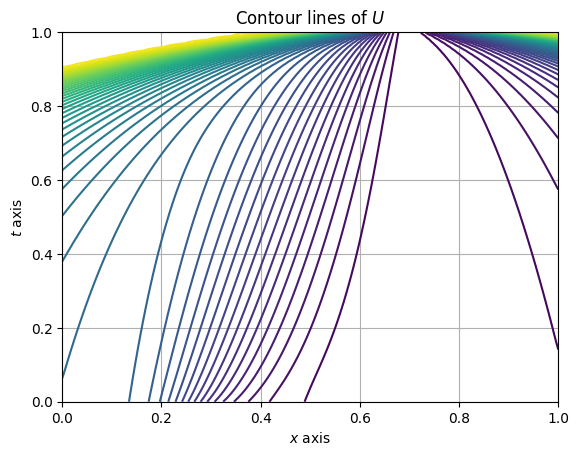

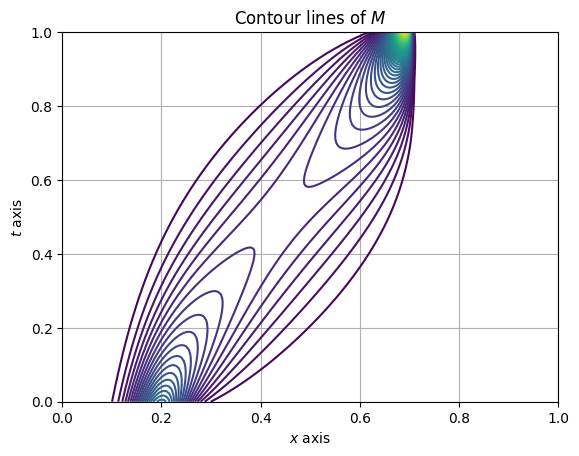

In [63]:
# Initial conditions
M = np.zeros((NT+1, Nh))
M[:] = m0_in_func(space_grid)

U = np.zeros((NT+1, Nh))
U[:] = phi(space_grid)

# Solving the equations
U_solv, M_solv = Fixed_Point_Method(U, M)

# Saving the results
file_name_suffix = f"beta{str(beta).replace('.', 'virgule')}"

with open(f'U_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, U_solv)
with open(f'M_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, M_solv)

# Plotting the results
plt.contour(space_grid, time_grid, U_solv, levels=60)
plt.title("Contour lines of $U$")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.grid()
plt.show()

plt.contour(space_grid, time_grid, M_solv, levels=60)
plt.grid()
plt.title("Contour lines of $M$")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.show()

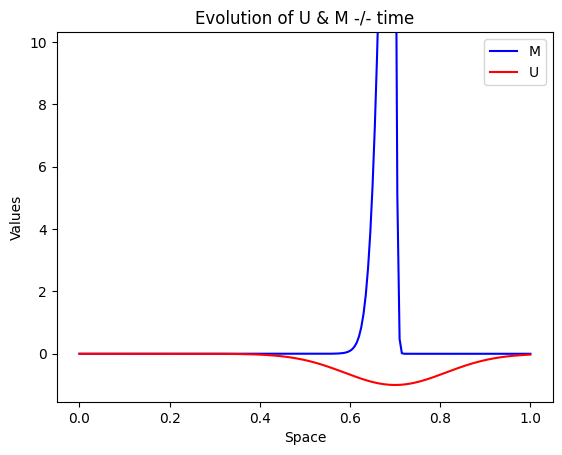

In [64]:
# Animation
fig, ax = plt.subplots()

line1, = ax.plot(space_grid, M_solv[0, :], color='blue', label='M')
line2, = ax.plot(space_grid, U_solv[0, :], color='red', label='U')

ax.legend(loc='best')
ax.set_title('Evolution of U & M -/- time')
ax.set_xlabel('Space')
ax.set_ylabel('Values')

def init():
    line1.set_ydata([np.nan] * len(space_grid))
    line2.set_ydata([np.nan] * len(space_grid))
    return line1, line2

def animate(i):
    line1.set_ydata(M_solv[i, :])  
    line2.set_ydata(U_solv[i, :])  
    return line1, line2

# Create animation
ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=100, blit=True, frames=len(time_grid)
)
ani.save('video_mfg.gif', writer='pillow')


# Display animation
HTML(ani.to_jshtml())

## Twist to the problem : Mean field Control



The key points modification lies in the Hamitonian operator modification, the residual function modifiation and some of the jacobian.


Iteration 0, previous norm: inf, theta: 0.09, elapsed time: 8.106231689453125e-06
Iteration 1, previous norm: 33.014973099163306, theta: 0.09, elapsed time: 0.6319129467010498
Iteration 2, previous norm: 29.73375158326399, theta: 0.09, elapsed time: 0.7527689933776855
Iteration 3, previous norm: 28.453234673373096, theta: 0.09, elapsed time: 0.9306759834289551
Iteration 4, previous norm: 37.0239906479726, theta: 0.081, elapsed time: 1.1168150901794434
Iteration 5, previous norm: 28.02141100950119, theta: 0.081, elapsed time: 1.2663280963897705
Iteration 6, previous norm: 23.98556419749321, theta: 0.081, elapsed time: 1.39320707321167
Iteration 7, previous norm: 21.58268295739233, theta: 0.081, elapsed time: 1.5282340049743652
Iteration 8, previous norm: 19.37557855773128, theta: 0.081, elapsed time: 1.7185389995574951
Iteration 9, previous norm: 16.927376478327094, theta: 0.081, elapsed time: 1.860469102859497
Iteration 10, previous norm: 15.040520953271793, theta: 0.081, elapsed time:

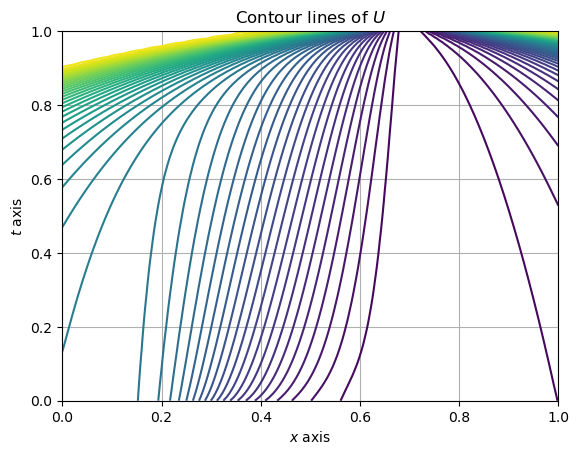

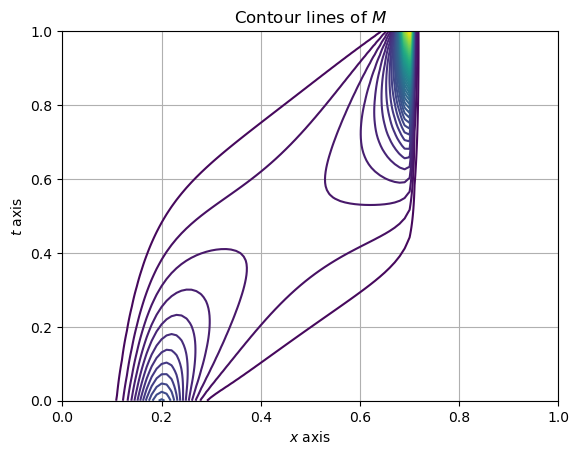

In [3]:

T = 1
params = {
    0: (2, 0.1, 1, 0.5, 0.02), # theta = 0.09 & the set of parameters considered for the comparison note that f0_tilda will be put to 0 ! 
}

# Selecting a parameter set
beta, c0, c1, alpha, sigma = params[0] # manually set the parameters here
nu = sigma**2/2
Nh = 101 # Number of space grid points
NT = 100 # Number of time grid points
dt = T/NT # Time step
h = 1/(Nh - 1) # Space step
time_grid = np.arange(0, T+dt, dt) # Time grid
space_grid = np.arange(0, 1+h, h) # Space grid
newton_stopping_criterion = 1e-12 # 1e-12 Seems to be too small
stopping_criterion = 1e-6 # Optimally we put 1e-6 but if it takes "too long" we can put 1e-3

theta = 0.09# to be changed depending on the parameter set

def m0(x):
    """
    Initial condition for the density m
    """
    return np.sqrt(300/np.pi) * np.exp(-300 * (x - 0.2)**2)

def phi(x, m=None):
    """
    phi function from the project sheet
    """
    return -np.exp(-40 * (x - 0.7)**2)


def m0_in_func(x):
    """
    replication of m0 function in the project sheet
    """
    return m0(x)

## Spatial Operators 

# Derivatives operators : @i 
D = np.diag([-1]*Nh) + np.diag([1]*(Nh-1), k=1)
D[Nh-1, Nh-1] = 0 # Boundary condition

# Derivatives operators : @i-1
D_prev = np.diag([1]*Nh) + np.diag([-1]*(Nh-1), k=-1)
D_prev[0, 0] = 0 # Boundary condition

# Laplacian
D_2 = np.diag([-2]*Nh) + np.diag([1]*(Nh-1), k=1) + np.diag([1]*(Nh-1), k=-1)
D_2[0, 0], D_2[Nh-1, Nh-1] = -1, -1 # Boundary conditions
D_2 = D_2/h**2


def compute_residuals_F(U_next, U_current, M_F):
    """
    Compute the residuals of the HJB equation
    """    
    F = - (U_next - U_current)/dt  - nu*D_2@U_current
    F +=  1/beta * (np.minimum(D@U_current / h, 0)**2 + (np.maximum(D_prev@U_current / h, 0))**2)**(beta/2) * 1 / ((c0 + c1*M_F)**alpha)
    F -= ((c1 * alpha  * M_F)/(beta *((c0 + c1*M_F)**(alpha+1)))) * (np.minimum(D@U_current / h, 0)**2 + (np.maximum(D_prev@U_current / h, 0))**2)**(beta/2)
    return F

def compute_jacobian_H_tilda(U, M_JH):
    """
    Compute the Jacobian of the H_tilda function
    """
    
    positive_part = np.maximum(D_prev@U, 0) 
    negative_part = - np.minimum(D@U, 0) 
     
    coef = positive_part**2 + negative_part**2
    coef = np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    diag = ((1/h**beta)      *(1/((c0 + c1 * M_JH)**alpha))* (negative_part + positive_part) * coef) # [i,i]
    diag_ = (-((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  positive_part * coef)[1:]  #[i+1, i]
    _diag = (-((1/h**beta)) *(1/((c0 + c1 * M_JH)**alpha))*  negative_part* coef)[:-1]   #[i, i+1]
    
    JH = np.diag(diag_, k=-1) + np.diag(diag) + np.diag(_diag, k=+1) # Dense matrix for solve() methods
    
    return JH

def compute_jacobian(U, M_JB):
    """
    Compute the Jacobian  for the HJB equation
    """
    
    positive_part = np.maximum(D_prev@U, 0) 
    negative_part = - np.minimum(D@U, 0) 
    
    coef = positive_part**2 + negative_part**2
    coef = np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    diag = ((1/h**beta)        *((1/((c0 + c1 * M_JB)**alpha)) - ((c1*alpha*M_JB)/((c0 + c1*M_JB)**(alpha+1))))* (negative_part + positive_part) * coef) # [i,i]
    diag_ = (-1 *((1/h**beta)) *((1/((c0 + c1 * M_JB)**alpha)) - ((c1*alpha*M_JB)/((c0 + c1*M_JB)**(alpha+1))))*  positive_part * coef)[1:]  #[i+1, i]
    _diag = (-1 *((1/h**beta)) *((1/((c0 + c1 * M_JB)**alpha)) - ((c1*alpha*M_JB)/((c0 + c1*M_JB)**(alpha+1))))*  negative_part* coef)[:-1]   #[i, i+1]
    
    jacobian_matrix = np.zeros((3, U.size))
    jacobian_matrix[0, 1:] = _diag - nu/h**2
    jacobian_matrix[1] = diag + 1/dt + 2*nu/h**2 # résoudre Id / delta t et donc le reporter sur les equations 
    jacobian_matrix[2, :-1] = diag_ - nu/h**2

    
    return jacobian_matrix

def Newton_Raphson(U, M):
    """
    Newton Raphson method to solve the HJB equation
    """
    U_k = U.copy()
    normF = np.inf
    while normF > newton_stopping_criterion:
        F = compute_residuals_F(U, U_k, M) 
        J = compute_jacobian(U_k, M) 
       
        # To avoid numerical error when c0 is too small (as a term will explode) we decide to not divide by delta t but rewrite our equation to solve it
        F *= dt
        J *= dt
        
        U_k = U_k - scipy.linalg.solve_banded((1, 1), J, F) # Solve the linear system as the matrix is banded we use solve_banded
        
        normF = np.linalg.norm(F)

    return U_k # Return the solution at the end of the Newton Raphson method


def solve_HJB(M_HJB):
    """
    Solve the HJB equation
    """
    U_hat = np.zeros(M_HJB.shape)
    U_hat[NT] = phi(space_grid)

    # Backward loop
    for n in range(NT-1, -1, -1):
        U_hat[n] = Newton_Raphson(U_hat[n+1], M_HJB[n+1]) # Solve the HJB equation for each time step

    return U_hat # Return the solution of the HJB equation

def solve_KFP(U, M_old):
    """
    Solve the KFP equation
    """
    
    M_hat = np.zeros(U.shape)
    M_hat[0] = m0_in_func(space_grid)
    
    # Forward loop
    for n in range(NT):
        JH = compute_jacobian_H_tilda(U[n], M_old[n])
        M_hat[n+1] = np.linalg.solve(np.identity(Nh) - nu*dt*D_2+dt*JH.T, M_hat[n])

    return M_hat

def Fixed_Point_Method(U_fixed, M_fixed, theta):
    """
    Fixed Point Method to solve the HJB and KFP equations
    """
    t0 = time.time() # Start time
    k = 0 # Iteration counter
    
    norm_increment = np.inf # Initialize the norm of the increment
    
    
    while norm_increment > stopping_criterion:
        print(f"Iteration {k}, previous norm: {norm_increment}, theta: {theta}, elapsed time: {time.time() - t0}")
        
        U_hat = solve_HJB(M_fixed)
        M_hat = solve_KFP(U_hat, M_fixed)

        U_new = (1 - theta) * U_fixed + theta * U_hat
        M_new = (1 - theta) * M_fixed + theta * M_hat

        increment = np.hstack((U_new - U_fixed, M_new - M_fixed))
        
        norm_increment_new = np.linalg.norm(increment)
        if norm_increment_new > norm_increment:
            theta *= 0.9
        norm_increment = norm_increment_new
        
        k += 1

        U_fixed, M_fixed = U_new, M_new
           
    return U_new, M_new

# Initial conditions
M_2 = np.zeros((NT+1, Nh))
M_2[:] = m0_in_func(space_grid)

U_2 = np.zeros((NT+1, Nh))
U_2[:] = phi(space_grid)

# Solving the equations
U_solv_2, M_solv_2 = Fixed_Point_Method(U_2, M_2, theta)

# Saving the results
file_name_suffix = f"beta{str(beta).replace('.', 'virgule')}"

with open(f'U_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, U_solv_2)
with open(f'M_{file_name_suffix}.npy', 'wb') as f:
    np.save(f, M_solv_2)

# Plotting the results
plt.contour(space_grid, time_grid, U_solv_2, levels=60)
plt.title("Contour lines of $U$")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.grid()
plt.show()

plt.contour(space_grid, time_grid, M_solv_2, levels=60)
plt.grid()
plt.title("Contour lines of $M$")
plt.xlabel("$x$ axis")
plt.ylabel("$t$ axis")
plt.show()

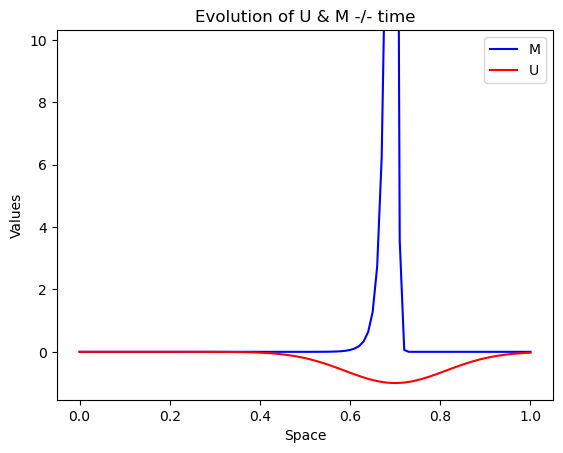

In [4]:
# Animation
fig, ax = plt.subplots()

line1, = ax.plot(space_grid, M_solv_2[0, :], color='blue', label='M')
line2, = ax.plot(space_grid, U_solv_2[0, :], color='red', label='U')

ax.legend(loc='best')
ax.set_title('Evolution of U & M -/- time')
ax.set_xlabel('Space')
ax.set_ylabel('Values')

def init():
    line1.set_ydata([np.nan] * len(space_grid))
    line2.set_ydata([np.nan] * len(space_grid))
    return line1, line2

def animate(i):
    line1.set_ydata(M_solv_2[i, :])  
    line2.set_ydata(U_solv_2[i, :])  
    return line1, line2

# Create animation
ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=100, blit=True, frames=len(time_grid)
)
ani.save('video_mfc.gif', writer='pillow')


# Display animation
HTML(ani.to_jshtml())